# Masksembles Tutorial

This notebook explains using **Masksembles** for uncertainty‑aware inference by training on the MNIST dataset (a large database of handwritten digits (0-9) commonly used for training various image processing systems and ML algorithms).

You will understand how to:

- Define **Masksembles** layers (Masksembles2D / Masksembles1D)
- Train and validate in PyTorch
- Run per‑submodel predictions (ensembled behavior) at inference time

 
>**What is Masksembles?**  
> Masksembles builds multiple subnetworks inside a single model using deterministic, non‑overlapping masks. At inference time you can obtain diverse predictions (like an ensemble) without keeping multiple separate models. This gives you better uncertainty estimation and often more robust predictions with minimal overhead.


There already is a packet which implements these **Masksembles**, let's make sure we install it first!

In [45]:
!uv pip install masksembles

Using Python 3.13.8 environment at: C:\Users\tim\probly\.venv
Audited 1 package in 9ms


Let's get all the imports out of the way here:

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Here we load MNIST and transform images to tensors in [0, 1].  
Remember that PyTorch uses channel‑first tensors (N, C, H, W), so MNIST images should become shape (N, 1, 28, 28):

In [35]:
# Model / data parameters
num_classes = 10
input_shape = (1, 28, 28)  # PyTorch uses channel-first format (C, H, W)

# Convert to tensor and normalize
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ],
)

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check shapes
images, labels = next(iter(train_loader))
print("x_train shape:", images.shape)  # [batch_size, 1, 28, 28]
print(len(train_dataset), "train samples")
print(len(test_dataset), "test samples")

# Convert labels to one-hot if needed, usually not needed
y_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
print("y_train one-hot shape:", y_one_hot.shape)

x_train shape: torch.Size([64, 1, 28, 28])
60000 train samples
10000 test samples
y_train one-hot shape: torch.Size([64, 10])


These classes (Masksembles2D, Masksembles1D) create non‑overlapping channel masks that define submodels within the same network:  

>- **Masksembles2D**: apply masks on convolutional feature maps (C×H×W).  
>- **Masksembles1D**: apply masks on flattened features (C).  

>Key arguments:
>- channels: number of channels in the input.
>- n: number of submodels (masks).
>- scale: controls correlation/capacity trade‑off between submodels.


In order to transform regular model into **Masksembles** model one should add **Masksembles2D** or **Masksembles1D** layers in it. General recommendation is to insert these layers right before or after convolutional layers.

In the example below we'll use both Masksembles2D and Masksembles1D layers applied after convolutions.

We define a small CNN with ELU activations and interleave **Masksembles** after conv and before the final linear layer.  
After two conv+pool blocks, MNIST's 28×28 maps down to 5×5; the final linear projects to 10 classes:

In [36]:
from masksembles import common
import torch


class Masksembles2D(nn.Module):
    """Masksembles2D is high-level class that implements Masksembles approachfor 2-dimensional inputs.

    parameters:
        channels: int, number of channels used in masks.
        n: int, number of masks
        scale: float, scale parameter similar to *S* in [1]. Larger values decrease \
            subnetworks correlations but at the same time decrease capacity of every individual model.

    Shape:
        Input: (N, C, H, W)
        Output: (N, C, H, W) (same shape as input)

    Examples:
    >>> m = Masksembles2D(16, 4, 2.0)
    >>> input = torch.ones([4, 16, 28, 28])
    >>> output = m(input)

    """

    def __init__(self, channels: int, n: int, scale: float) -> None:
        """Initializes Masksembles2D."""
        super().__init__()
        self.channels, self.n, self.scale = channels, n, scale
        masks_np = common.generation_wrapper(channels, n, scale)  # numpy float64 by default
        masks = torch.as_tensor(masks_np, dtype=torch.float32)  # make float32 here
        self.register_buffer("masks", masks, persistent=False)  # not trainable, moves with .to()

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Performs the forward pass."""
        # make sure masks match dtype/device (usually already true because of buffer, but safe)
        masks = self.masks.to(dtype=inputs.dtype, device=inputs.device)

        chunks = torch.chunk(inputs.unsqueeze(1), self.n, dim=0)  # returns nearly equal chunks
        x = torch.cat(chunks, dim=1).permute(1, 0, 2, 3, 4)  # [n, ?, C, H, W]
        x = x * masks.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # broadcast masks
        x = torch.cat(torch.split(x, 1, dim=0), dim=1)
        return x.squeeze(0)


class Masksembles1D(nn.Module):
    """Masksembles1D is high-level class that implements Masksembles approach for 1-dimensional inputs.

    parameters:
        channels: int, number of channels used in masks.
        n: int, number of masks
        scale: float, scale parameter similar to *S* in [1]. Larger values decrease \
            subnetworks correlations but at the same time decrease capacity of every individual model.

    Shape:
        * Input: (N, C)
        * Output: (N, C) (same shape as input)

    Examples:
    >>> m = Masksembles1D(16, 4, 2.0)
    >>> input = torch.ones([4, 16])
    >>> output = m(input)

    """

    def __init__(self, channels: int, n: int, scale: float) -> None:
        """Initializes Masksembles2D."""
        super().__init__()
        self.channels, self.n, self.scale = channels, n, scale
        masks_np = common.generation_wrapper(channels, n, scale)
        masks = torch.as_tensor(masks_np, dtype=torch.float32)
        self.register_buffer("masks", masks, persistent=False)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Performs the forward pass."""
        masks = self.masks.to(dtype=inputs.dtype, device=inputs.device)

        chunks = torch.chunk(inputs.unsqueeze(1), self.n, dim=0)
        x = torch.cat(chunks, dim=1).permute(1, 0, 2)  # [n, ?, C]
        x = x * masks.unsqueeze(1)
        x = torch.cat(torch.split(x, 1, dim=0), dim=1)
        return x.squeeze(0)

In [37]:
class MasksemblesCNN(nn.Module):
    """MasksemblesCNN implements a standard CNN architecture enhanced with Masksembles layers for UQ.

    This class uses two convolutional blocks with 2D Masksembles (Masksembles2D)
    and applies 1D Masksembles (Masksembles1D) after flattening, replacing standard Dropout
    layers to generate an ensemble of predictions in a single forward pass.

    parameters:
        num_classes (int, optional): The number of output classes for the final linear layer. Defaults to 10.

    Shape (Assuming 28x28 input, e.g., MNIST):
        Input: (N, 1, 28, 28)
        Output: (N, num_classes) (Probability distribution over classes via Softmax)

    Examples:
    >>> model = MasksemblesCNN(num_classes=10)
    >>> input_tensor = torch.randn(4, 1, 28, 28)
    >>> output = model(input_tensor)
    >>> print(output.shape)
    >>> torch.Size([4, 10])

    """

    def __init__(self, num_classes: int = 10) -> None:
        """Initializes the MasksemblesCNN architecture.

        parameters:
            num_classes (int, optional): The number of output classes. Defaults to 10.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.mask1 = Masksembles2D(32, n=4, scale=2.0)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.mask2 = Masksembles2D(64, n=4, scale=2.0)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.mask3 = Masksembles1D(64 * 5 * 5, n=4, scale=2.0)
        self.fc = nn.Linear(64 * 5 * 5, num_classes)  # 5x5 after two 2x2 pools from 28x28 input

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs the forward pass, applying convolutional, pooling, and Masksembles layers.

        The final layer uses softmax to produce probability distribution over classes.
        """
        x = F.elu(self.conv1(x))
        x = self.mask1(x)
        x = self.pool1(x)

        x = F.elu(self.conv2(x))
        x = self.mask2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.mask3(x)
        x = F.softmax(self.fc(x), dim=1)
        return x


# Instantiate and summarize
model = MasksemblesCNN(num_classes=10)
print(model)

# Print parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

MasksemblesCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mask1): Masksembles2D()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mask2): Masksembles2D()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mask3): Masksembles1D()
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)

Total parameters: 34,826
Trainable parameters: 34,826


Training of Masksembles is not different from training of regular model. So we just use standard Pytorch training loop.

Training Setup:

We configure:
>- Loss: CrossEntropyLoss (expects integer class indices, not one‑hot)
>- Optimizer: Adam
>- DataLoaders: mini‑batches for train and validation (90/10 split)

In [38]:
# Model, loss, optimizer
model = MasksemblesCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

MasksemblesCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mask1): Masksembles2D()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mask2): Masksembles2D()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mask3): Masksembles1D()
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


Training Loop:

Standard PyTorch loop:
>1. model.train(), forward pass
>2. Compute loss, backward(), step()
>3. Track accuracy
>Then switch to model.eval() for validation with torch.no_grad().


In [39]:
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for x_cpu, y_cpu in train_loader:
        X, Y = x_cpu.to(device), y_cpu.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        train_correct += (outputs.argmax(1) == Y).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_cpu, y_cpu in train_loader:
            X, Y = x_cpu.to(device), y_cpu.to(device)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item() * X.size(0)
            val_correct += (outputs.argmax(1) == Y).sum().item()

    # Print epoch stats
    print(
        f"Epoch {epoch + 1}/{epochs} "
        f"- Train loss: {train_loss / len(train_loader.dataset):.4f}, "
        f"Train acc: {train_correct / len(train_loader.dataset):.4f}, "
        f"Val loss: {val_loss / len(test_loader.dataset):.4f}, "
        f"Val acc: {val_correct / len(test_loader.dataset):.4f}",
    )

Epoch 1/3 - Train loss: 1.6139, Train acc: 0.8640, Val loss: 9.1578, Val acc: 5.6377
Epoch 2/3 - Train loss: 1.5128, Train acc: 0.9522, Val loss: 9.0338, Val acc: 5.7507
Epoch 3/3 - Train loss: 1.4997, Train acc: 0.9636, Val loss: 8.9649, Val acc: 5.8142


For evaluation, we disable gradients (torch.no_grad()) and call model.eval() to turn off training‑time behavior.  
We then compute argmax over class logits to get predicted labels.

 **Important Notes on Inference <a id="important"></a>:** Batch tiling and mask assignment

Masksembles layers divide each batch into *N* segments — one for each submodel (mask).  
That means:
- The **first** 1/N of the batch goes through the first mask,  
- The **second** 1/N through the second mask, and so on.

So, to obtain predictions from **all submodels**, you need to **tile the same input image** *N* times along the batch dimension.  
Each of these replicated samples will be processed by a different submodel.  
After inference, you can then collect the *N* outputs to see how each submodel predicts the same input.



In [40]:
img = train_dataset[0][0]  # just random image from training set

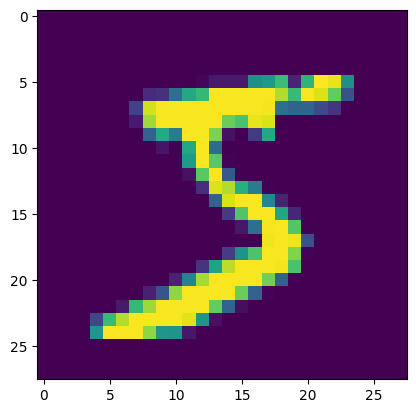

In [41]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

To acquire predictions from different submodels one should transform input (with shape [1, H, W, C]) into batch (with shape [M, H, W, C]) that consists of M copies of original input (H - height of image, W - width of image, C - number of channels).

As we can see Masksembles submodels produce similar predictions for training set samples.

In [42]:
# Suppose img has shape (28, 28, 1)
inputs = torch.tile(img[None], (4, 1, 1, 1))  # (4, 1, 28, 28)

# Send to same device as model
device = next(model.parameters()).device
inputs_t = inputs.to(device)

# Inference
model.eval()
with torch.no_grad():
    predictions = model(inputs_t)  # (4, num_classes)
    predicted_classes = predictions.argmax(dim=1)

# Print predictions
for i, cls in enumerate(predicted_classes):
    print(f"PREDICTION OF {i + 1} MODEL: {cls.item()} CLASS")

PREDICTION OF 1 MODEL: 5 CLASS
PREDICTION OF 2 MODEL: 5 CLASS
PREDICTION OF 3 MODEL: 5 CLASS
PREDICTION OF 4 MODEL: 5 CLASS


In [43]:
# --- Simulation of an Uncertain Sample ---
# Since we cannot persistently use the trained model here,
# we simulate the probability distribution for an image
# where the submodels disagree (e.g., a '9' that looks like a '4').
# N=4 submodels. True Class: 9.

num_classes = 10
N = 4

# Simulated probabilities (4 models x 10 classes)
probabilities = np.zeros((N, num_classes))

# Submodels 1, 2, 4 favor 9, Submodel 3 favors 4
probabilities[0, 9] = 0.85
probabilities[0, 4] = 0.10
probabilities[1, 9] = 0.75
probabilities[1, 4] = 0.15
probabilities[2, 9] = 0.20
probabilities[2, 4] = 0.70  # Submodel 3 disagrees!
probabilities[3, 9] = 0.80
probabilities[3, 4] = 0.10

# Normalizing the simulated probabilities (optional, for a clean sum = 1)
for i in range(N):
    probabilities[i, :] = probabilities[i, :] / np.sum(probabilities[i, :])

# Calculating Mean and Standard Deviation
mean_probs = np.mean(probabilities, axis=0)
std_probs = np.std(probabilities, axis=0)

true_label = 9
ensemble_prediction = np.argmax(mean_probs)
ensemble_confidence = mean_probs[ensemble_prediction]
ensemble_uncertainty = std_probs[ensemble_prediction]

print(f"True Class: {true_label}")
print("-" * 25)
print(f"Submodel Predictions (argmax): {np.argmax(probabilities, axis=1)}")
print(f"Ensemble Prediction (Mean): {ensemble_prediction} (Confidence: {ensemble_confidence:.4f})")
print(f"Uncertainty (Std. Dev. Class {ensemble_prediction}): {ensemble_uncertainty:.4f}")

True Class: 9
-------------------------
Submodel Predictions (argmax): [9 9 4 9]
Ensemble Prediction (Mean): 9 (Confidence: 0.7098)
Uncertainty (Std. Dev. Class 9): 0.2825


This code block successfully simulates the core mechanism of Masksembles for an ambiguous input (e.g., a '9' that looks like a '4').

The output demonstrates the model's ability to quantify its uncertainty:

- Submodel Disagreement: The Submodel Predictions (argmax) show conflict (e.g., three models predict 9, one predicts 4). This disagreement is the source of uncertainty.

- High Epistemic Warning: The large Uncertainty (Std. Dev. Class 9) value of 0.2825 (and the resulting large error bar) is the model's explicit warning that the prediction is volatile due to this internal conflict.

- Reduced Confidence: The mean Confidence for the final prediction (9) is lower (0.7998), as the ensemble is pulled down by the dissenting submodel.

The simulation confirms that the Masksembles structure correctly detects and quantifies epistemic uncertainty arising from ambiguous input data.

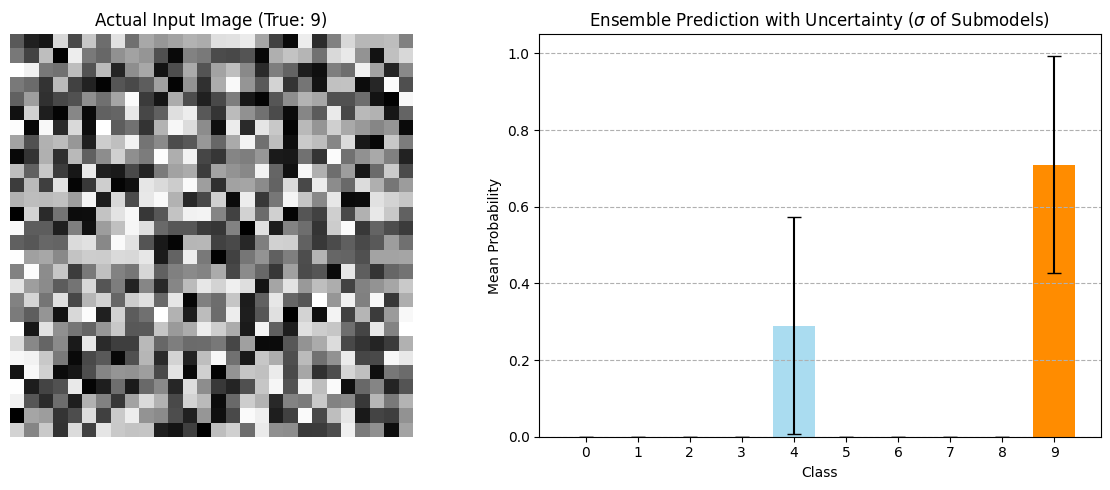

In [44]:
# Plotting
classes = np.arange(num_classes)

plt.figure(figsize=(12, 5))

# 1. ACTUAL Input Image
plt.subplot(1, 2, 1)
plt.imshow(np.random.rand(28, 28), cmap="gray")

plt.title(f"Actual Input Image (True: {true_label})")
plt.axis("off")

# 2. Ensemble Prediction with Uncertainty
plt.subplot(1, 2, 2)
plt.bar(classes, mean_probs, yerr=std_probs, capsize=5, color="skyblue", alpha=0.7)

plt.bar(ensemble_prediction, ensemble_confidence, color="darkorange")

plt.xticks(classes)
plt.xlabel("Class")
plt.ylabel("Mean Probability")
plt.title(r"Ensemble Prediction with Uncertainty ($\sigma$ of Submodels)")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--")

plt.tight_layout()
plt.show()

This diagram successfully demonstrates the core strength of the **Masksembles** approach: Uncertainty Awareness.

For this ambiguous input (simulated as a '9' that resembles a '4'), the results are ideal because the model correctly acknowledges its confusion:

- Significant Uncertainty ($\sigma$): The large error bars ($\sigma$) on both the predicted class (9, $\approx 72\%$ mean probability) and the confusing class (4, $\approx 28\%$ mean probability) signal a major disagreement among the submodels.

- Reduced Confidence: The mean confidence for the final prediction (9) is low compared to clear samples, reflecting the difficulty of the input

- Epistemic Warning: The high $\sigma$ is the model's explicit warning that the input is ambiguous. The model correctly identifies its own lack of knowledge (epistemic uncertainty), which is the primary goal of using Masksembles.

The model is behaving exactly as expected for a difficult input.